In [1]:
import os
import time
import json
import ijson
import datetime
import itertools

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as mticker
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.mixture import GaussianMixture as GMM
from scipy.optimize import fsolve


# 1. Slice to 2-hour, east/west boundfile

- The i-24 raw files should be stored in the folder named "selected"

In [13]:
def get_start_timestamp(filename):

    print(f'processing {filename}...')

    raw_files_dict = {'post2' : '11-22',
                      'post3' : '11-23', 
                      'post8' : '11-28',
                      'post9' : '11-29',
                      'post10' : '11-30',
                      'post11' : '12-01',
                      'post12' : '12-02'}
    
    month_day = raw_files_dict[filename.split('.')[0].split('_')[-1]]
    month, day = int(month_day.split('-')[0]), int(month_day.split('-')[1])

    print(f'The target date is {month}-{day}-2022.')
    start_timestamp = int(datetime.datetime(2022, month, day, 21, 0, 0).timestamp())

    return day, month, start_timestamp

def save_records(input_filename, day, month, start_timestamp):
    input_filename = f'selected/raw/{input_filename}'
    for direction_idx, direction in zip([-1, 1], ["west", "east"]):
        for init_timestamp, hour in zip([start_timestamp, start_timestamp+3600*2], [21, 23]):
            records_to_save = []  

            print(f"Saving {direction}bound trajectories in {month}-{day}-2022 from {hour} to {hour+2}...")

            with open(input_filename, 'r') as input_file:
                parser = ijson.items(input_file, 'item', use_float=True)
                for record in parser:
                    if (
                        (record["direction"] == direction_idx) and
                        (record["first_timestamp"] >= init_timestamp) and
                        (record["last_timestamp"] < init_timestamp+2*3600) and
                        (record["last_timestamp"] - record["first_timestamp"] > 0.08)):
                        records_to_save.append(record)  # Add the record to the list

            with open(f'selected/processed/{direction}bound_{month:02d}_{day:02d}_{hour}_{hour+2}.json', 'w') as outfile:
                json.dump(records_to_save, outfile)
                print(f'{direction}bound_{month:02d}_{day:02d}_{hour}_{hour+2}.json saved.')
    print(' ')

raw_files = os.listdir("selected/raw")

for raw_file in raw_files:
    day, month, start_timestamp = get_start_timestamp(raw_file)
    save_records(raw_file, day, month, start_timestamp)

processing 638450a3dd50d54aa5af0cf6__post8.json...
The target date is 11-28-2022.
Saving westbound trajectories in 11-28-2022 from 21 to 23...
westbound_11_28_21_23.json saved.
 
Saving westbound trajectories in 11-28-2022 from 23 to 25...
westbound_11_28_23_25.json saved.
 
Saving eastbound trajectories in 11-28-2022 from 21 to 23...
eastbound_11_28_21_23.json saved.
 
Saving eastbound trajectories in 11-28-2022 from 23 to 25...
eastbound_11_28_23_25.json saved.
 
processing 6386d89efb3ff533c12df167__post10.json...
The target date is 11-30-2022.
Saving westbound trajectories in 11-30-2022 from 21 to 23...
westbound_11_30_21_23.json saved.
 
Saving westbound trajectories in 11-30-2022 from 23 to 25...
westbound_11_30_23_25.json saved.
 
Saving eastbound trajectories in 11-30-2022 from 21 to 23...
eastbound_11_30_21_23.json saved.
 
Saving eastbound trajectories in 11-30-2022 from 23 to 25...
eastbound_11_30_23_25.json saved.
 
processing 63882be478f0cb97981425df__post11.json...
The tar

# 2. Classify the lane of each file

Target data is eastbound_11_29_21_23.json


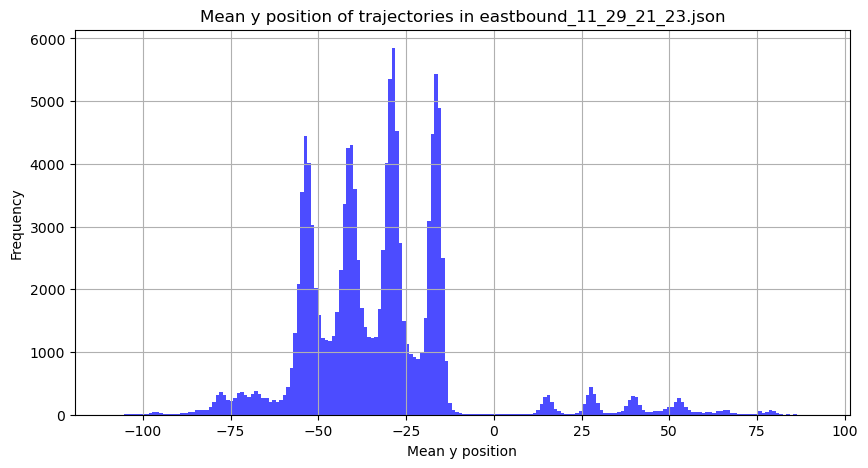

Target data is eastbound_11_29_23_25.json


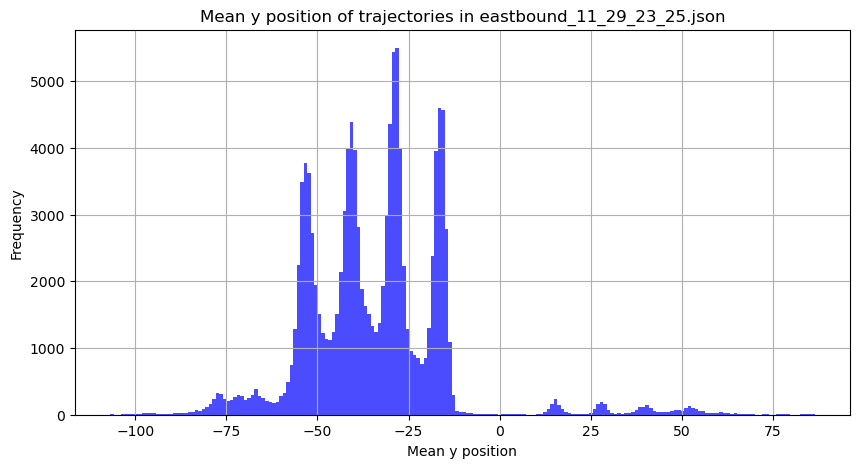

Target data is eastbound_11_30_21_23.json


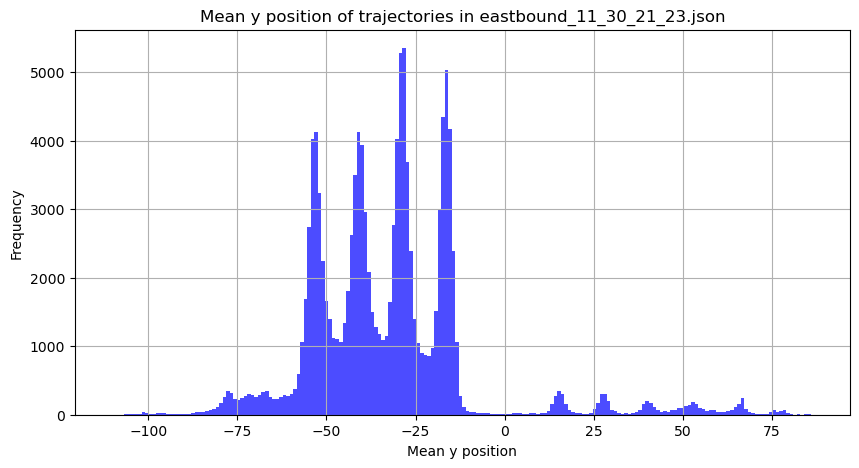

Target data is eastbound_11_30_23_25.json


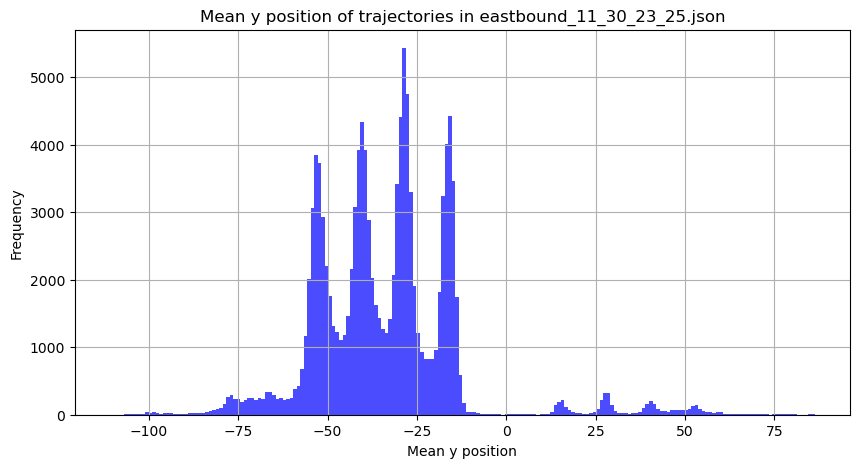

Target data is eastbound_12_01_21_23.json


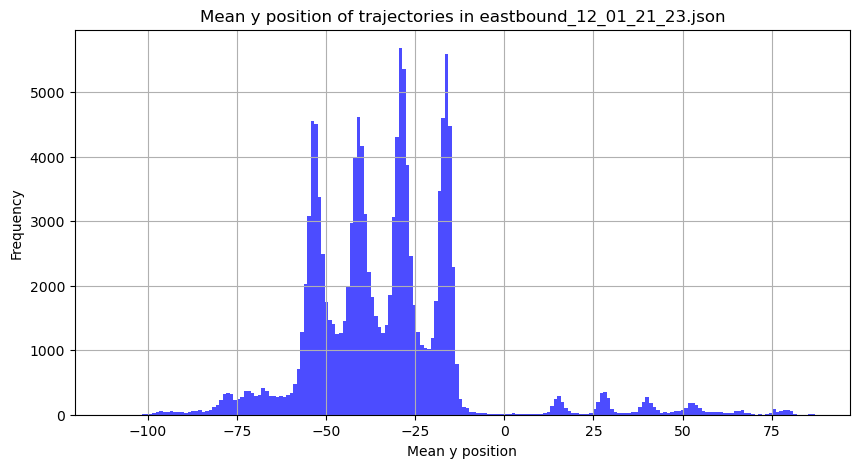

Target data is eastbound_12_01_23_25.json


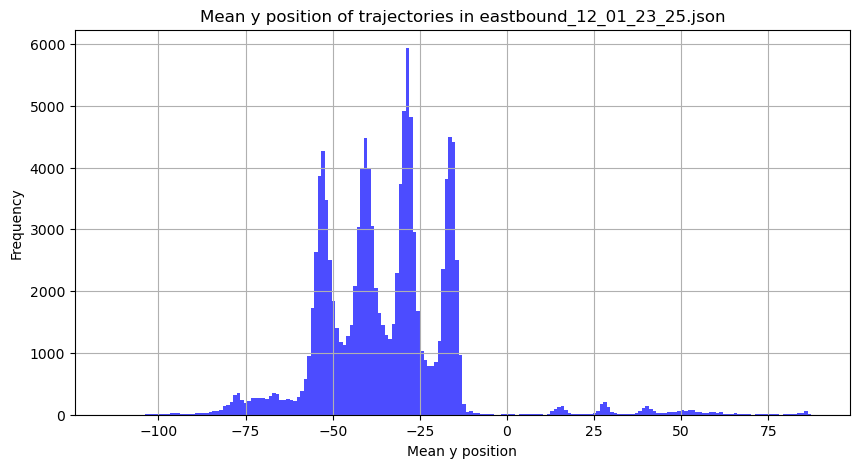

Target data is westbound_11_29_21_23.json


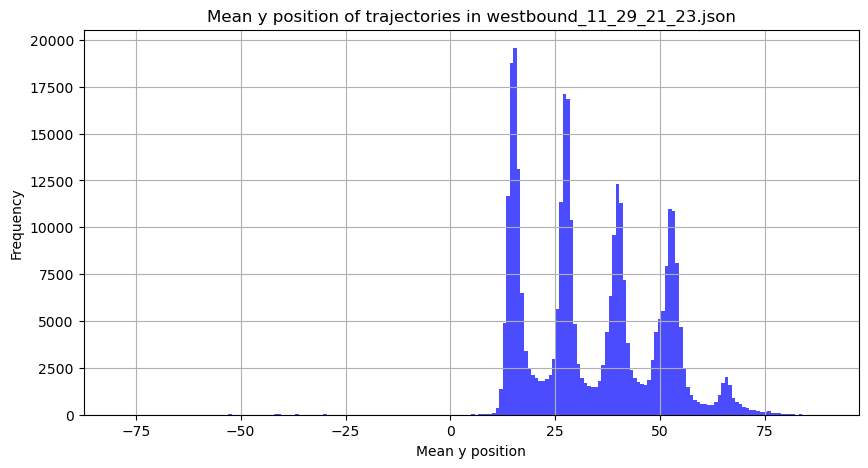

Target data is westbound_11_29_23_25.json


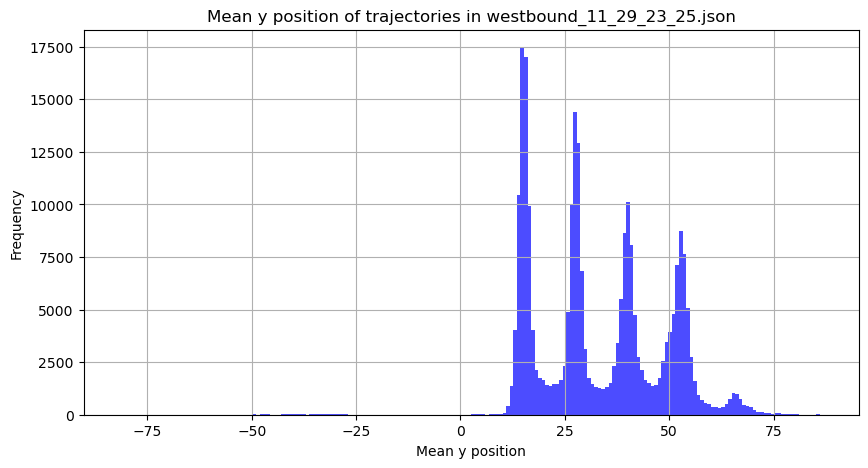

Target data is westbound_11_30_21_23.json


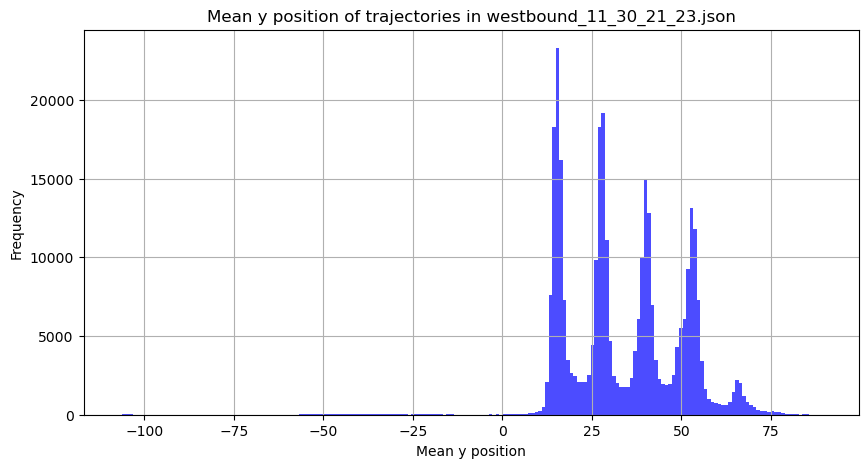

Target data is westbound_11_30_23_25.json


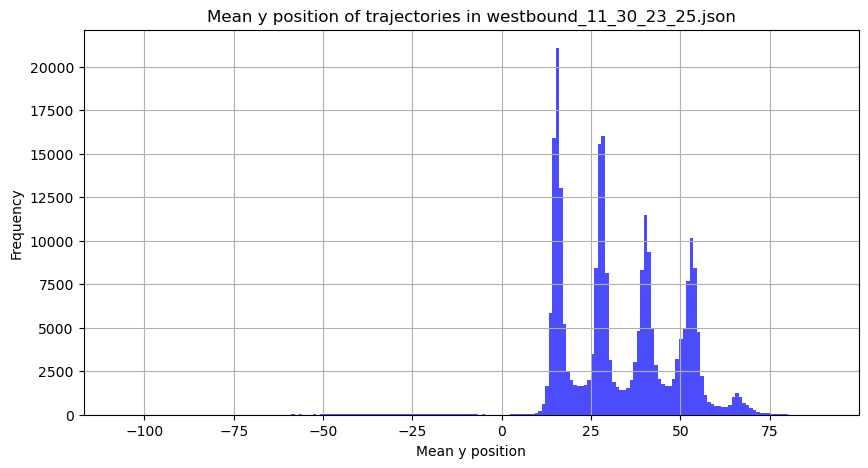

Target data is westbound_12_01_21_23.json


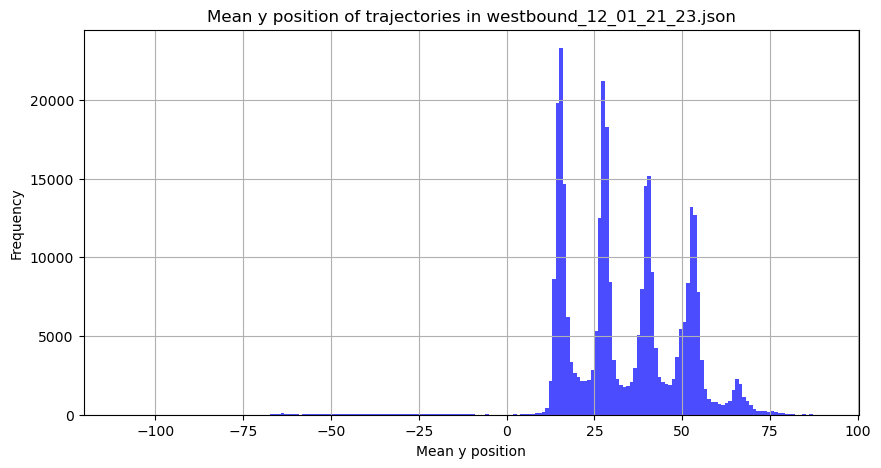

Target data is westbound_12_01_23_25.json


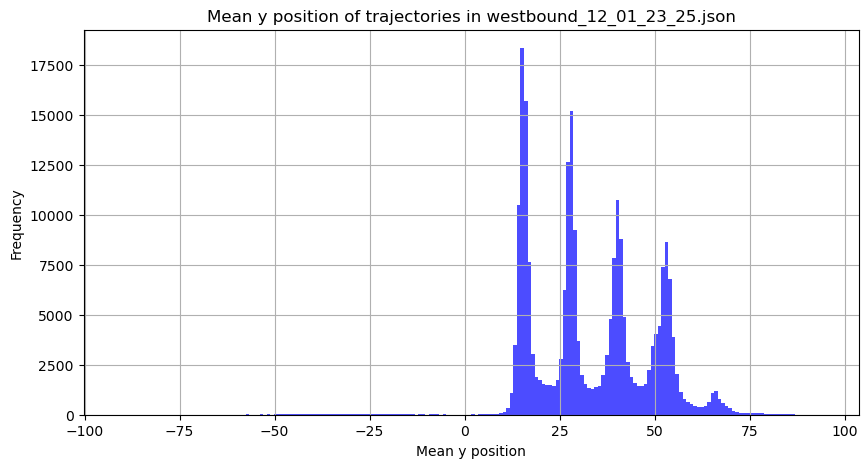

In [2]:
processed_files = os.listdir("selected/processed")

# plot example of westbound and eastbound for each day

for processed_file in processed_files:
    processed_file_split = processed_file.split('_')

    if (processed_file_split[2] in ['29', '30', '01']):

        print(f'Target data is {processed_file}')
        traj_df = pd.read_json(f'selected/processed/{processed_file}')

        # Draw a mean y position histogram   
        traj_df["mean_y"] = traj_df["y_position"].apply(lambda x: np.mean(x))

        fig, ax = plt.subplots(figsize=(10, 5))
        ax.hist(traj_df["mean_y"], bins=200, color='blue', alpha=0.7)
        ax.set_title(f'Mean y position of trajectories in {processed_file}')
        ax.grid(True)
        ax.set_xlabel('Mean y position')
        ax.set_ylabel('Frequency')
        plt.show()

Target data is eastbound_11_29_21_23.json


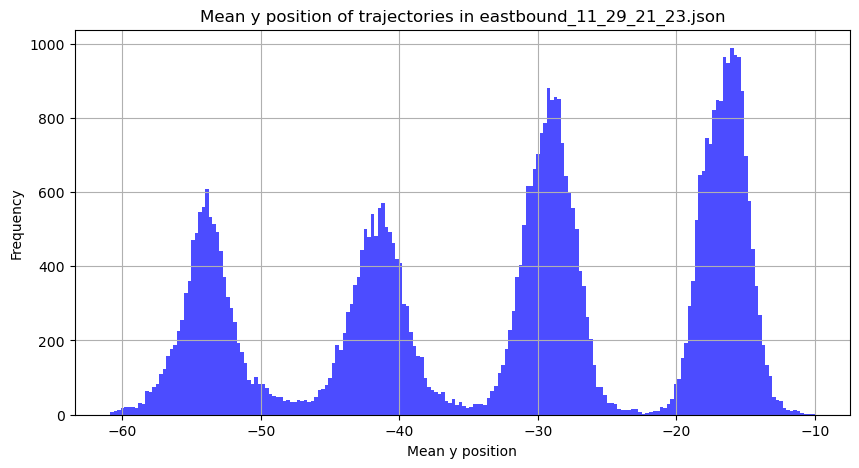

Target data is eastbound_11_29_23_25.json


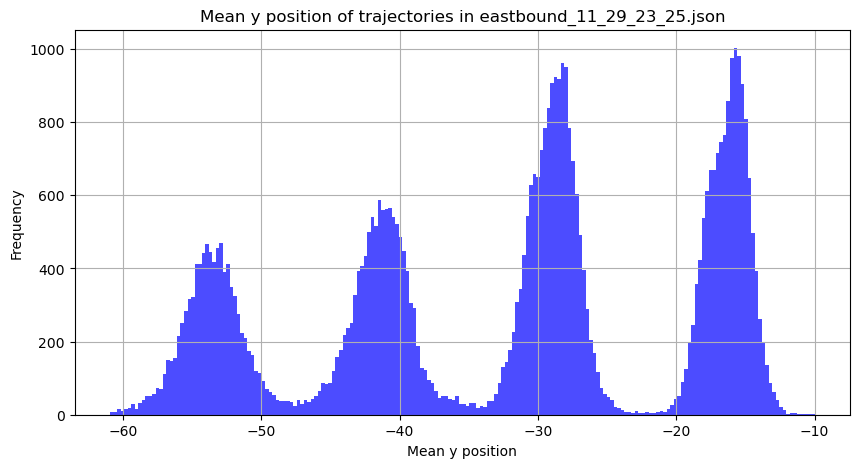

Target data is eastbound_11_30_21_23.json


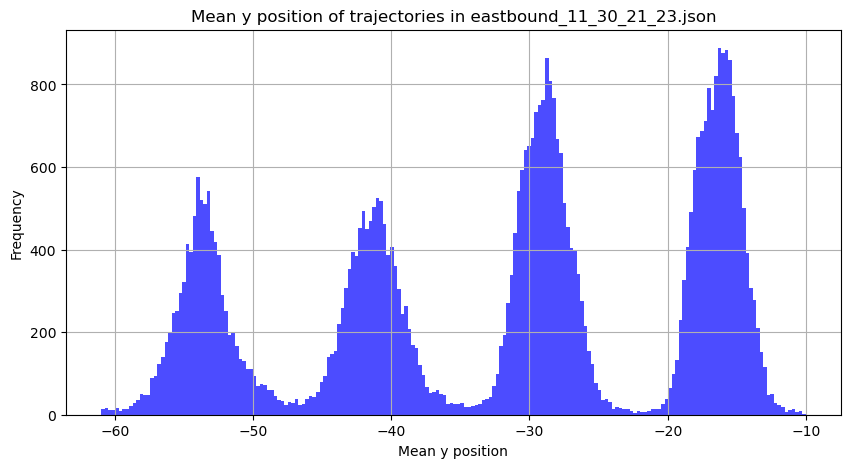

Target data is eastbound_11_30_23_25.json


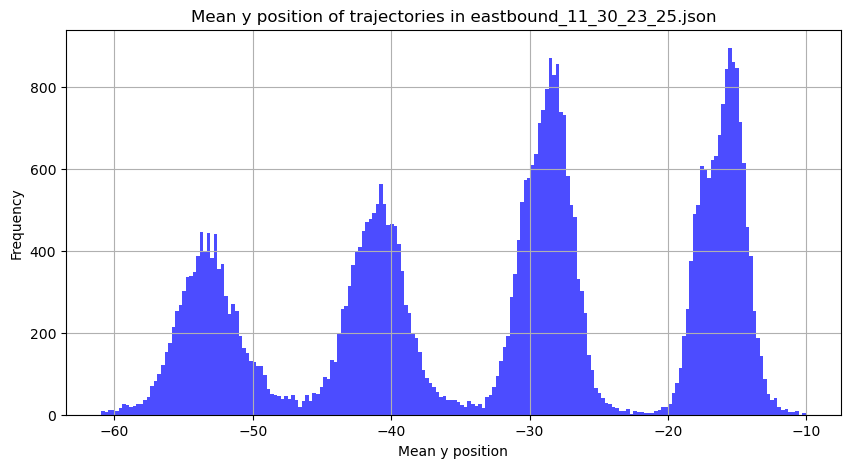

Target data is eastbound_12_01_21_23.json


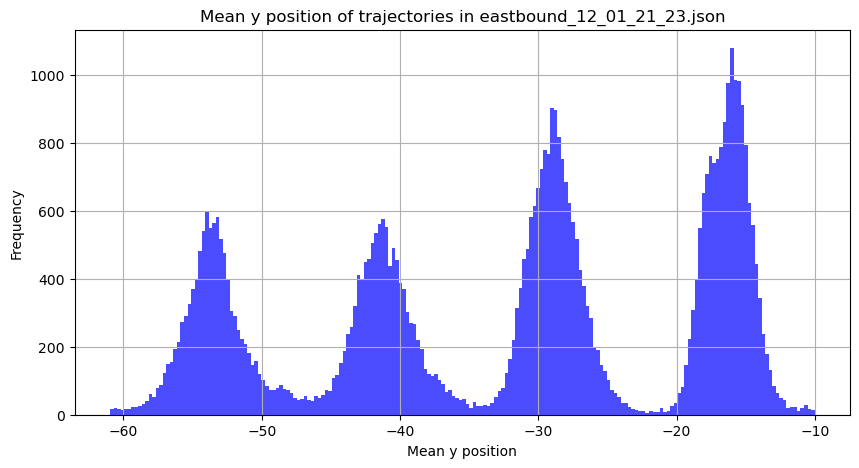

Target data is eastbound_12_01_23_25.json


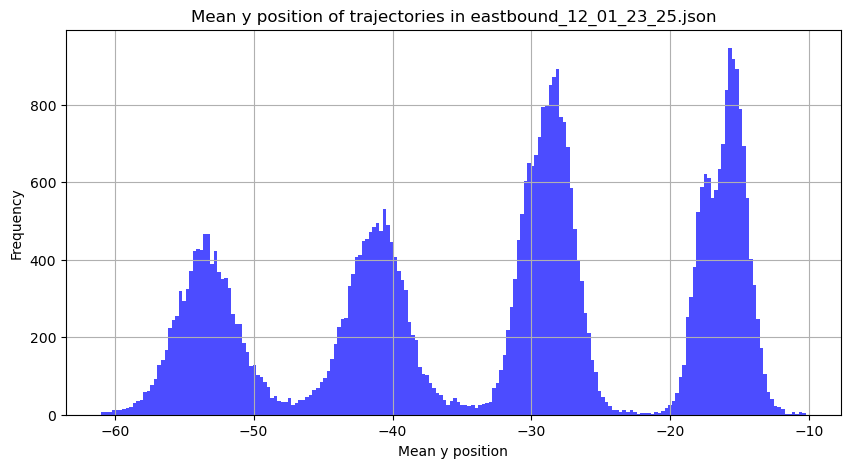

Target data is westbound_11_29_21_23.json


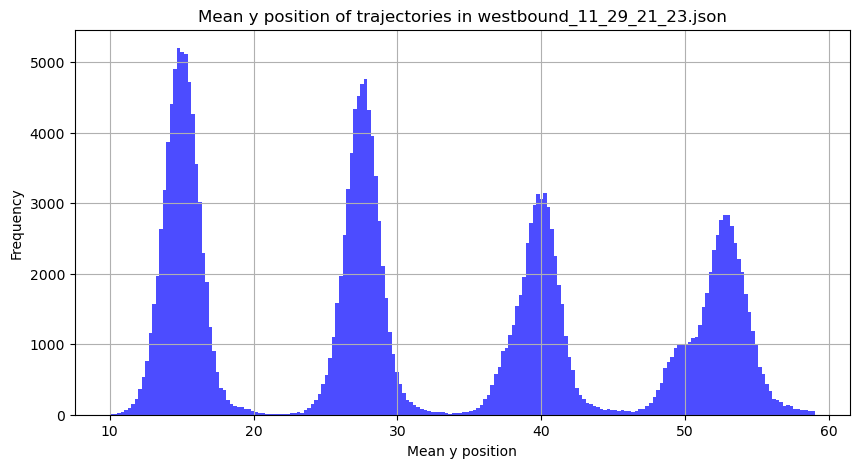

Target data is westbound_11_29_23_25.json


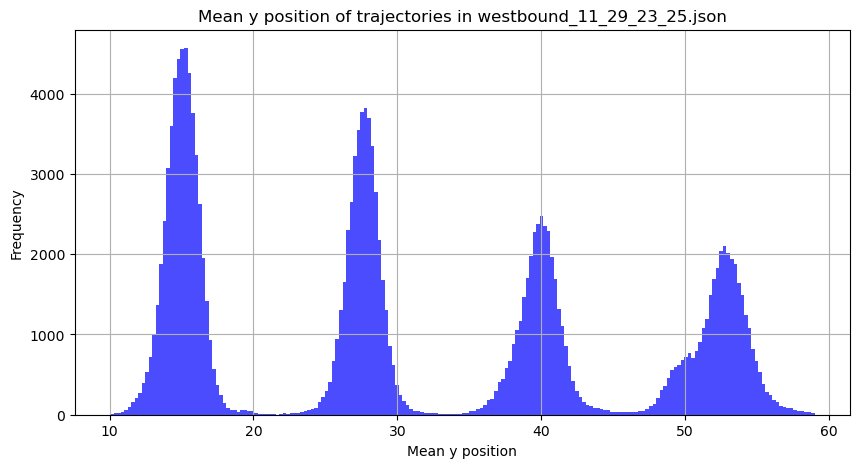

Target data is westbound_11_30_21_23.json


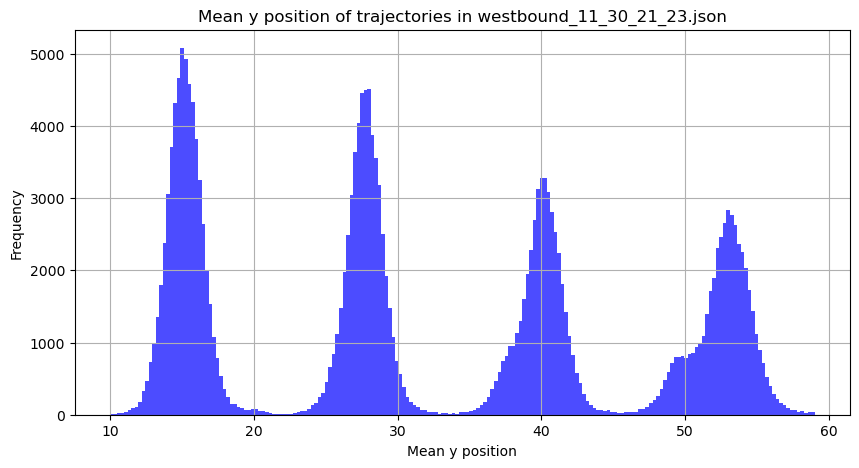

Target data is westbound_11_30_23_25.json


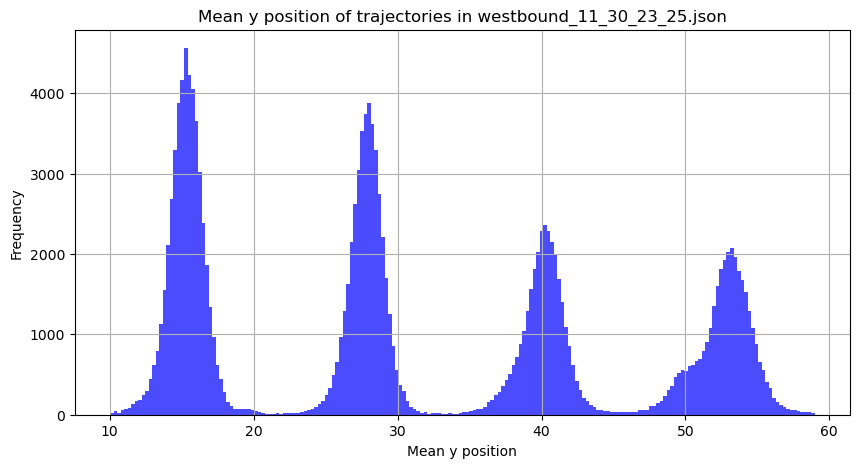

Target data is westbound_12_01_21_23.json


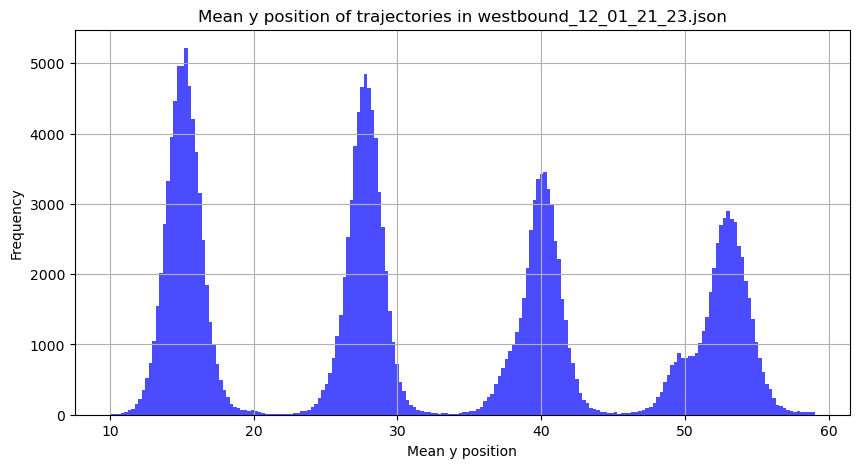

Target data is westbound_12_01_23_25.json


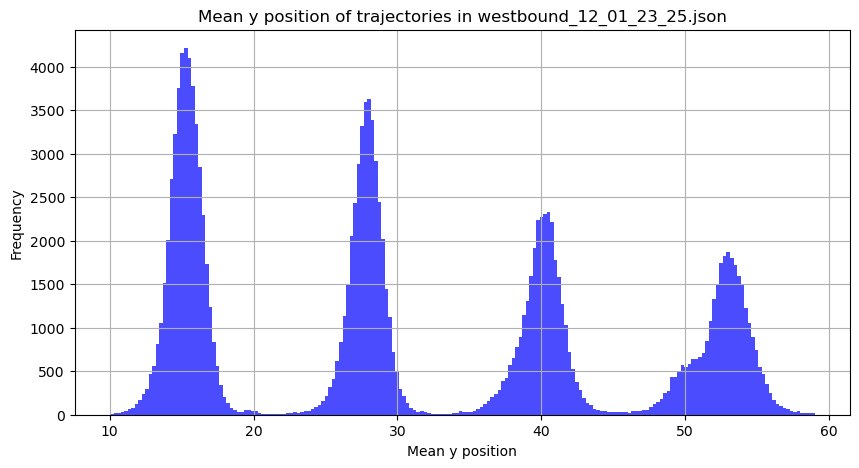

In [2]:
# plot the vehicles without lane changing

for processed_file in processed_files:
    processed_file_split = processed_file.split('_')

    if (processed_file_split[2] in ['29', '30', '01']):

        print(f'Target data is {processed_file}')
        traj_df = pd.read_json(f'selected/processed/{processed_file}')
        
        # plot only y_position that its max and min difference is less than 10
        traj_df["y_position_diff"] = traj_df["y_position"].apply(lambda x: np.max(x) - np.min(x))
        traj_df = traj_df[traj_df["y_position_diff"] < 5]

        traj_df["mean_y"] = traj_df["y_position"].apply(lambda x: np.mean(x))
        
        if processed_file_split[0] == 'westbound':
            traj_df = traj_df[(traj_df["mean_y"] > 10) & (traj_df["mean_y"] < 59)]
        elif processed_file_split[0] == 'eastbound':
            traj_df = traj_df[(traj_df["mean_y"] < -10) & (traj_df["mean_y"] > -61)]

        fig, ax = plt.subplots(figsize=(10, 5))
        ax.hist(traj_df["mean_y"], bins=200, color='blue', alpha=0.7)
        ax.set_title(f'Mean y position of trajectories in {processed_file}')
        ax.grid(True)
        ax.set_xlabel('Mean y position')
        ax.set_ylabel('Frequency')
        plt.show()

        del traj_df

Target data is eastbound_11_29_21_23.json
Intersecting point between components 1 and 2: -32.52631527984405
Intersecting point between components 1 and 3: -40.60393087361489
Intersecting point between components 1 and 4: -47.728023839739336
Intersecting point between components 2 and 3: -22.43484617399961
Intersecting point between components 2 and 4: -27.152982756216826
Intersecting point between components 3 and 4: -34.882452140751056


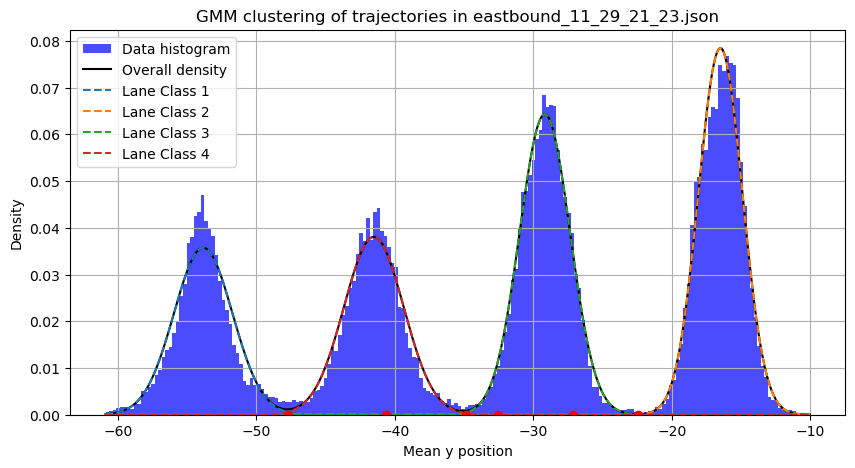

Target data is eastbound_11_29_23_25.json
Intersecting point between components 1 and 2: -26.61928797716574
Intersecting point between components 1 and 3: -34.53720183485465
Intersecting point between components 1 and 4: -47.31997720902455
Intersecting point between components 2 and 3: -22.172726638545825
Intersecting point between components 2 and 4: -31.335343722004843
Intersecting point between components 3 and 4: -39.78826889598329


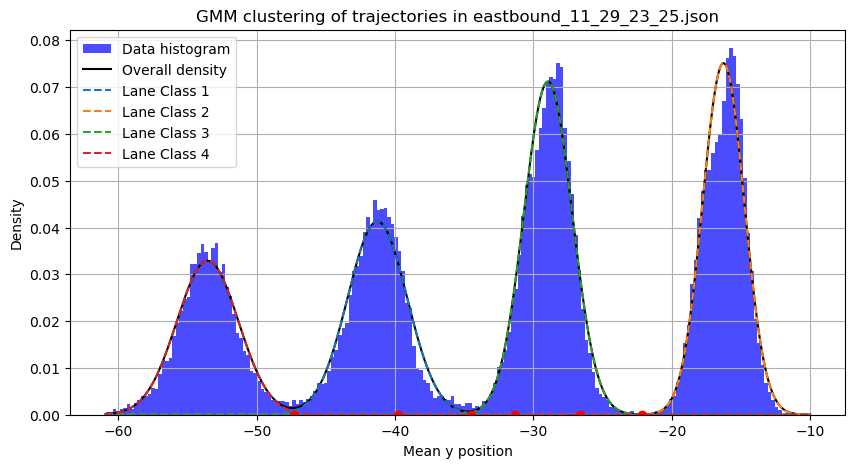

Target data is eastbound_11_30_21_23.json
Intersecting point between components 1 and 2: -27.085963191581033
Intersecting point between components 1 and 3: -22.296157907908626
Intersecting point between components 1 and 4: -32.33802647499614
Intersecting point between components 2 and 3: -34.594416004231775
Intersecting point between components 2 and 4: -47.39079313567871
Intersecting point between components 3 and 4: -40.17086712078636


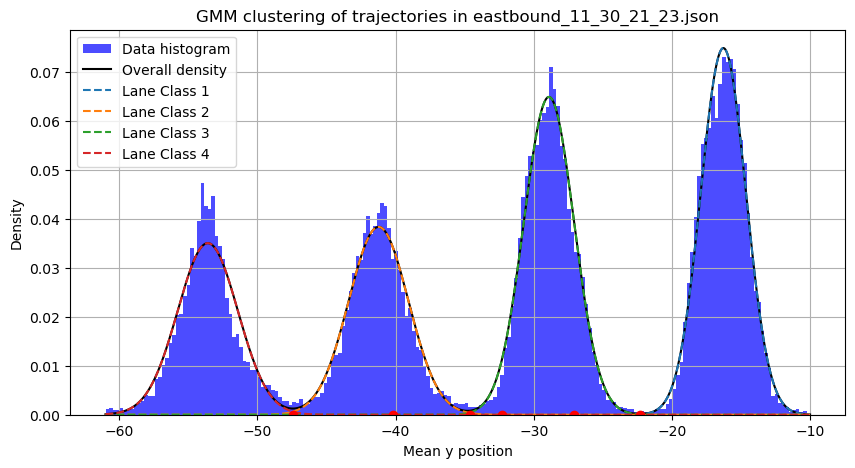

Target data is eastbound_11_30_23_25.json
Intersecting point between components 1 and 2: -30.89334707266864
Intersecting point between components 1 and 3: -22.0183804119855
Intersecting point between components 1 and 4: -26.56569445859327
Intersecting point between components 2 and 3: -39.257716334829354
Intersecting point between components 2 and 4: -46.838089851805314
Intersecting point between components 3 and 4: -34.30095357508313


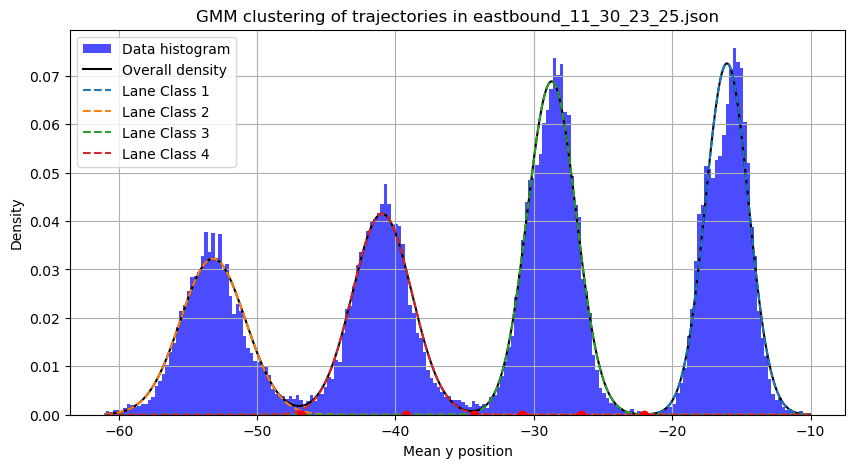

Target data is eastbound_12_01_21_23.json
Intersecting point between components 1 and 2: -26.676420045426358
Intersecting point between components 1 and 3: -22.083218927059406
Intersecting point between components 1 and 4: -31.728833170021264
Intersecting point between components 2 and 3: -34.5408791931863
Intersecting point between components 2 and 4: -47.3383282275124
Intersecting point between components 3 and 4: -40.08253095865826


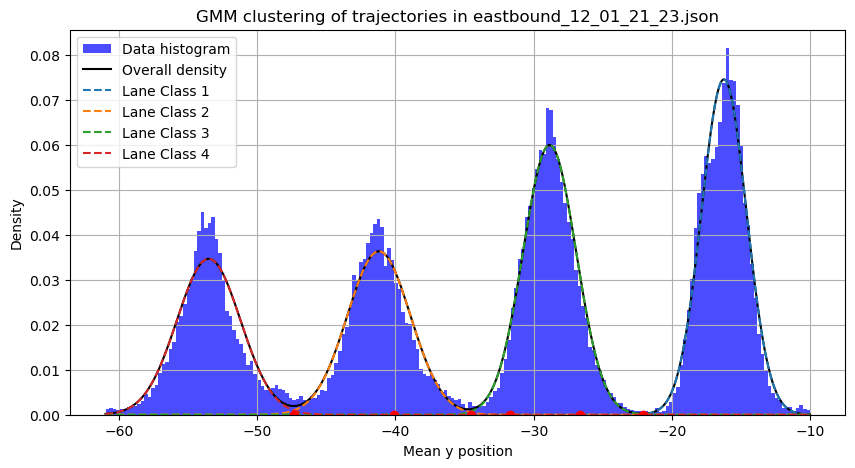

Target data is eastbound_12_01_23_25.json
Intersecting point between components 1 and 2: -31.06933112112455
Intersecting point between components 1 and 3: -39.49362320795919
Intersecting point between components 1 and 4: -47.18136436698322
Intersecting point between components 2 and 3: -22.04313640545393
Intersecting point between components 2 and 4: -26.35840050196003
Intersecting point between components 3 and 4: -34.311275830343


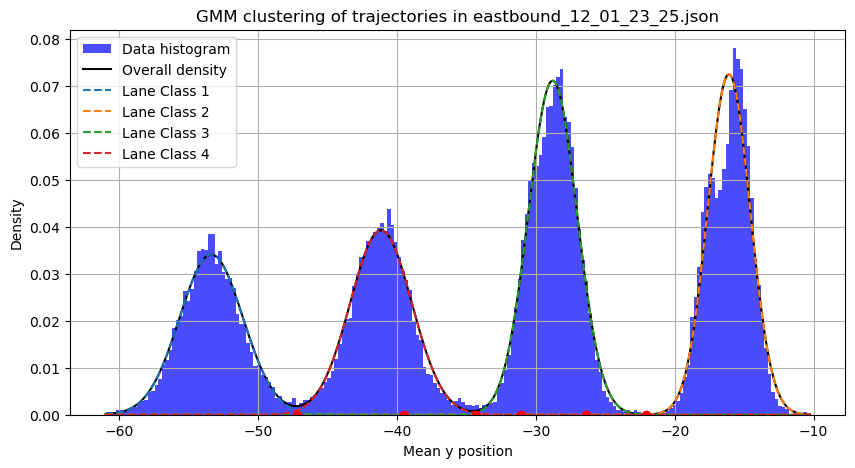

Target data is westbound_11_29_21_23.json
Intersecting point between components 1 and 2: 37.24737150764265
Intersecting point between components 1 and 3: 29.534591918567262
Intersecting point between components 1 and 4: 45.292617627873796
Intersecting point between components 2 and 3: 21.290379732117877
Intersecting point between components 2 and 4: 33.122213533393506
Intersecting point between components 3 and 4: 26.225224947754192


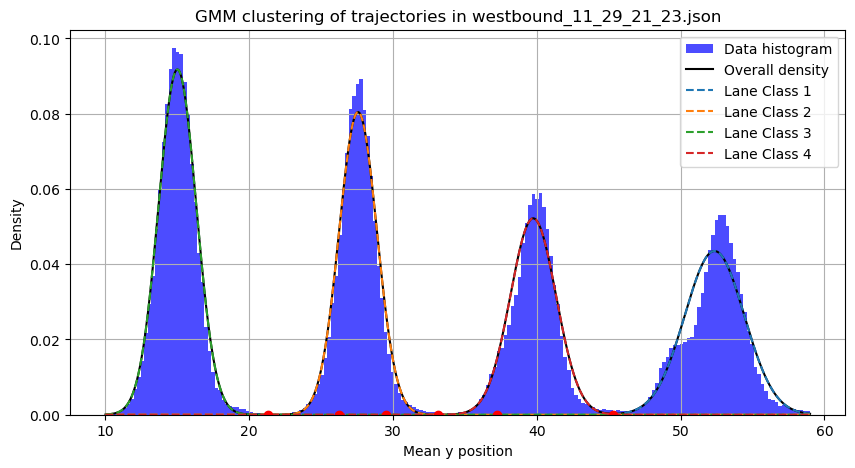

Target data is westbound_11_29_23_25.json
Intersecting point between components 1 and 2: 29.26959146726463
Intersecting point between components 1 and 3: 36.98161575589329
Intersecting point between components 1 and 4: 45.35158542454928
Intersecting point between components 2 and 3: 21.39445421798785
Intersecting point between components 2 and 4: 26.10916608880873
Intersecting point between components 3 and 4: 33.05233494697788


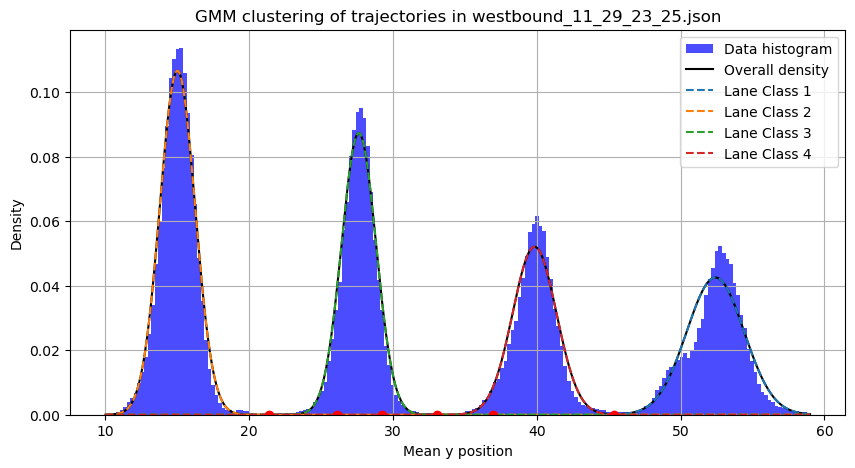

Target data is westbound_11_30_21_23.json
Intersecting point between components 1 and 2: 37.59582293658495
Intersecting point between components 1 and 3: 33.31365793187165
Intersecting point between components 1 and 4: 21.453647710717448
Intersecting point between components 2 and 3: 45.5546088490472
Intersecting point between components 2 and 4: 29.939939608512276
Intersecting point between components 3 and 4: 26.426609933615694


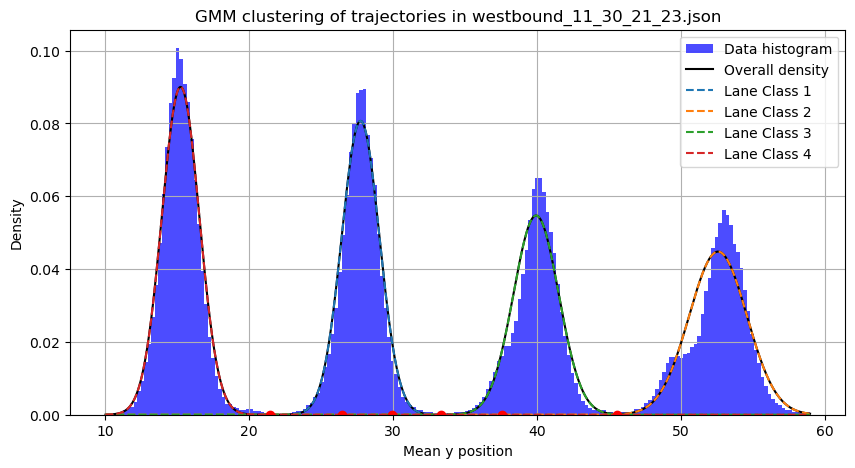

Target data is westbound_11_30_23_25.json
Intersecting point between components 1 and 2: 21.669246771181815
Intersecting point between components 1 and 3: 37.5139035062042
Intersecting point between components 1 and 4: 33.27978654461737
Intersecting point between components 2 and 3: 30.099820258301555
Intersecting point between components 2 and 4: 26.45350111880031
Intersecting point between components 3 and 4: 45.748339502976556


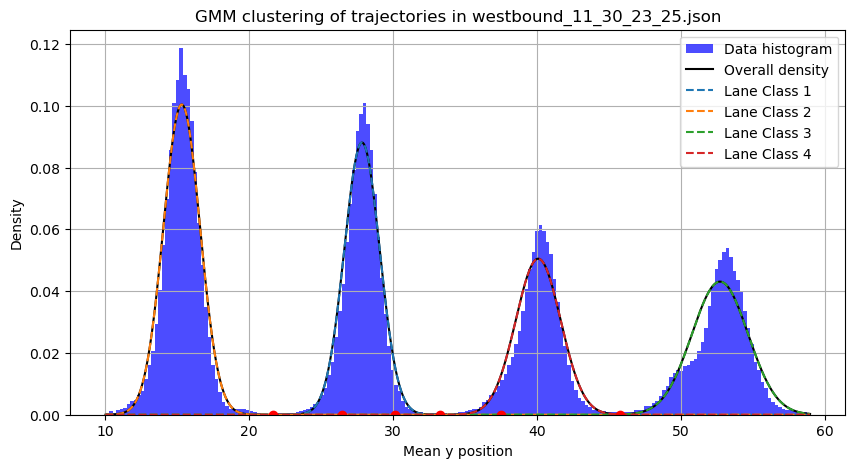

Target data is westbound_12_01_21_23.json
Intersecting point between components 1 and 2: 37.58444065686621
Intersecting point between components 1 and 3: 21.489741910376143
Intersecting point between components 1 and 4: 33.33885307358541
Intersecting point between components 2 and 3: 30.075166628218927
Intersecting point between components 2 and 4: 45.47775315868922
Intersecting point between components 3 and 4: 26.58797062976491


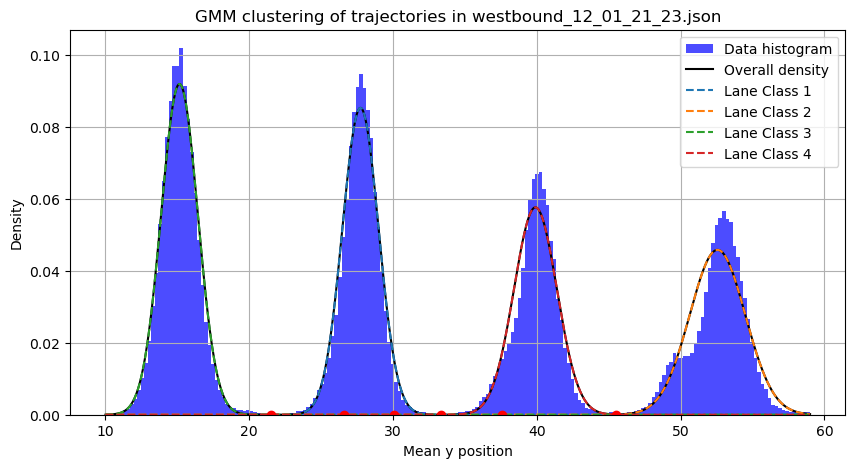

Target data is westbound_12_01_23_25.json
Intersecting point between components 1 and 2: 29.593277175203408
Intersecting point between components 1 and 3: 21.58713753648277
Intersecting point between components 1 and 4: 26.197037135096604
Intersecting point between components 2 and 3: 37.29691482288279
Intersecting point between components 2 and 4: 45.61181608567223
Intersecting point between components 3 and 4: 33.20379216806013


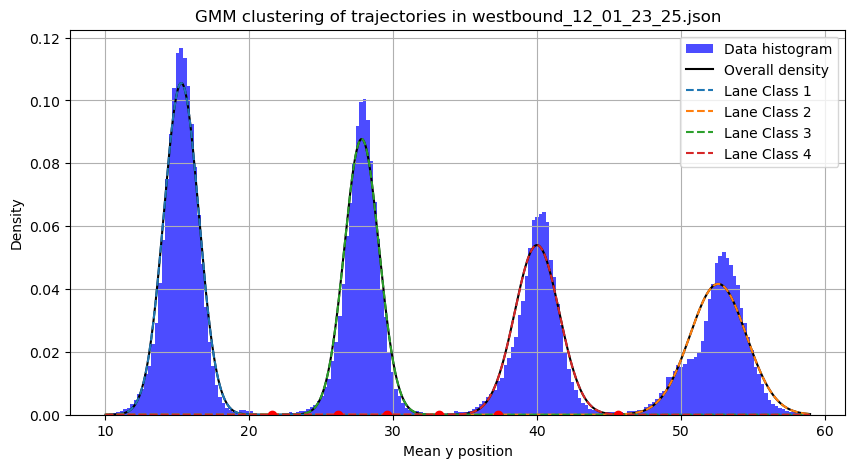

In [2]:
def find_intersection(func, x0):
    return fsolve(func, x0)

processed_files = os.listdir("selected/processed")

component_pairs = list(itertools.combinations(range(4), 2))

for processed_file in processed_files:
    processed_file_split = processed_file.split('_')

    if (processed_file_split[2] in ['29', '30', '01']):

        print(f'Target data is {processed_file}')
        traj_df = pd.read_json(f'selected/processed/{processed_file}')
        
        # plot only y_position that its max and min difference is less than 10
        traj_df["y_position_diff"] = traj_df["y_position"].apply(lambda x: np.max(x) - np.min(x))
        traj_df = traj_df[traj_df["y_position_diff"] < 5]

        traj_df["mean_y"] = traj_df["y_position"].apply(lambda x: np.mean(x))
        
        if processed_file_split[0] == 'westbound':
            traj_df = traj_df[(traj_df["mean_y"] > 10) & (traj_df["mean_y"] < 59)]
        elif processed_file_split[0] == 'eastbound':
            traj_df = traj_df[(traj_df["mean_y"] < -10) & (traj_df["mean_y"] > -61)]

        traj_df.reset_index(drop=True, inplace=True)

        X = np.array(traj_df["mean_y"]).reshape(-1, 1)

        gmm = GMM(n_components=4, random_state=0).fit(X)
        traj_df["label"] = gmm.predict(X)
        probabilities = gmm.predict_proba(X)
        traj_df['confidence_level'] = probabilities.max(axis=1)

        fig, ax = plt.subplots(figsize=(10, 5))
        ax.hist(traj_df["mean_y"], bins=200, density=True, color='blue', alpha=0.7, label='Data histogram')
        x = np.linspace(traj_df["mean_y"].min(), traj_df["mean_y"].max(), 1000).reshape(-1, 1)
        
        # Calculate the score samples to get the overall density
        logprob = gmm.score_samples(x)
        pdf = np.exp(logprob)
        responsibilities = gmm.predict_proba(x)
        pdf_individual = responsibilities * pdf[:, np.newaxis]
        
        # Plot the overall density and individual component densities
        ax.plot(x, pdf, '-k', label='Overall density')
        for i in range(gmm.n_components):
            ax.plot(x, pdf_individual[:, i], '--', label=f'Lane Class {i+1}')
        
        # Calculate and plot intersections for every unique pair
        for pair in component_pairs:
            # Extract indices for the components to compare
            i, j = pair

            def difference(x, gmm=gmm, i=i, j=j):
                means = gmm.means_.flatten()
                covariances = gmm.covariances_.flatten()
                diff = (1 / (np.sqrt(2 * np.pi * covariances[i])) * np.exp(-0.5 * ((x - means[i]) ** 2) / covariances[i])) - \
                    (1 / (np.sqrt(2 * np.pi * covariances[j])) * np.exp(-0.5 * ((x - means[j]) ** 2) / covariances[j]))
                return diff

            # Estimate an initial guess for the intersection point
            initial_guess = (gmm.means_[i] + gmm.means_[j]) / 2
            # Find the intersecting point using fsolve
            intersecting_point = find_intersection(difference, x0=initial_guess)
            print(f"Intersecting point between components {i+1} and {j+1}: {intersecting_point[0]}")
            ax.plot(intersecting_point, [difference(intersecting_point)], 'ro')  # Mark the intersecting point on the plot

        # Enhance the plot
        ax.set_title(f'GMM clustering of trajectories in {processed_file}')
        ax.set_xlabel('Mean y position')
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True)

        plt.show()

        del traj_df, gmm, X, probabilities, logprob, pdf, responsibilities, pdf_individual, x, difference, initial_guess, intersecting_point

# 3. Save the seperate time-space data based on the lanes

Lanes has been set 

![alt text](lane_info.jpg)

**Eastbound**

Lane 1: -10.6087 ~ -21.5660

Lane 2: -22.7924 ~ -33.9102

Lane 3: -35.1664 ~ -46.6609

Lane 4: -47.9845 ~ -60.3150


**Westbound**

Lane 1: 10.5740 ~ 20.9067

Lane 2: 22.0677 ~ 32.6316

Lane 3: 33.8328 ~ 44.8917

Lane 4: 46.1808 ~ 58.3253

In [2]:
east_list = [[-10.6087, -21.5660], [-22.7924, -33.9102], [-35.1664, -46.6609], [-47.9845, -60.3150]]
west_list = [[20.9067, 10.5740], [32.6316, 22.0677], [44.8917, 33.8328], [58.3253, 46.1808]]

processed_files = os.listdir("selected/processed")

for processed_file in processed_files:

    direction = processed_file[:9]

    print(processed_file[:-5])

    traj_df = pd.read_json(f'selected/processed/{processed_file}')

    traj_df["speed"] = traj_df.apply(lambda x: (np.diff(x["x_position"]) / np.diff(x["timestamp"])), axis=1)
    if direction == 'westbound':
        traj_df["speed"] = (-1) * traj_df["speed"]
    traj_df["x_position"] = traj_df["x_position"].apply(lambda x: x[1:])
    traj_df["timestamp"] = traj_df["timestamp"].apply(lambda x: x[1:])
    traj_df["y_position"] = traj_df["y_position"].apply(lambda x: x[1:])

    x_position_list = traj_df["x_position"].tolist()
    timestamp_list = traj_df["timestamp"].tolist()
    speed_list = traj_df["speed"].tolist()
    y_position_list = traj_df["y_position"].tolist()

    for x_position, timestamp, speed, y_position in zip(x_position_list, timestamp_list, speed_list, y_position_list):
        if len(x_position) != len(timestamp):
            print('x_position and timestamp length mismatch')
        if len(speed) != len(timestamp):
            print('speed and timestamp length mismatch')
        if len(timestamp) != len(y_position):
            print('timestamp and y_position length mismatch')

    # resahpe of x_position_list, timestamp_list, speed_list as 1 by n list
    x_position_list = np.concatenate(x_position_list)
    timestamp_list = np.concatenate(timestamp_list)
    speed_list = np.concatenate(speed_list)
    y_position_list = np.concatenate(y_position_list)

    # concate x_position_list, timestamp_list, speed_list as 3 by n list
    data_list = np.vstack((x_position_list, timestamp_list, speed_list, y_position_list))
    # print the shpaes of data_list
    print(f"Before triming speed over 160ft/sec: {data_list.shape}")
    data_list = data_list[:, data_list[2, :] < 160]
    print(f"After triming speed over 160ft/sec: {data_list.shape}")

    if direction == 'eastbound':
        lane_list = east_list
    elif direction == 'westbound':
        lane_list = west_list

    lane1_list = data_list[:3, (data_list[-1,:]>lane_list[0][1]) & (data_list[-1,:]<lane_list[0][0])]
    lane2_list = data_list[:3, (data_list[-1,:]>lane_list[1][1]) & (data_list[-1,:]<lane_list[1][0])]
    lane3_list = data_list[:3, (data_list[-1,:]>lane_list[2][1]) & (data_list[-1,:]<lane_list[2][0])]
    lane4_list = data_list[:3, (data_list[-1,:]>lane_list[3][1]) & (data_list[-1,:]<lane_list[3][0])]

    # get the max and min value from lane1_list[0], lane2_list[0], lane3_list[0], lane4_list[0]
    x_min = np.max([np.min(lane1_list[0]), np.min(lane2_list[0]), np.min(lane3_list[0]), np.min(lane4_list[0])])
    x_max = np.min([np.max(lane1_list[0]), np.max(lane2_list[0]), np.max(lane3_list[0]), np.max(lane4_list[0])])
    time_min = np.max([np.min(lane1_list[1]), np.min(lane2_list[1]), np.min(lane3_list[1]), np.min(lane4_list[1])])
    time_max = np.min([np.max(lane1_list[1]), np.max(lane2_list[1]), np.max(lane3_list[1]), np.max(lane4_list[1])])

    dx = 10
    dt = 1

    x_max_matrix = x_max - x_min
    time_max_matrix = time_max - time_min

    x_max_matrix = np.floor(x_max_matrix / dx)
    time_max_matrix = np.floor(time_max_matrix / dt)

    # Change the code above to for loop
    for lane_idx, lane_data in enumerate([lane1_list, lane2_list, lane3_list, lane4_list]):
        lane_data = lane_data[:, (lane_data[0]>x_min) & (lane_data[0]<x_max) & (lane_data[1]>time_min) & (lane_data[1]<time_max)]
        lane_data = lane_data[:, lane_data[2] != 0]
        lane_data = pd.DataFrame(lane_data.T, columns=['position', 'time', 'speed'])
        lane_data['position'] -= x_min
        lane_data['time'] -= time_min
        lane_data['position'] = np.floor(lane_data['position'] / dx)
        lane_data['time'] = np.floor(lane_data['time'] / dt)

        lane_data_mean = lane_data.groupby(['time', 'position']).mean().reset_index()

        speedmap = np.zeros((int(time_max_matrix)+1, int(x_max_matrix)+1))
        # speedmap[:] = np.nan

        if direction == 'eastbound':
            x = lane_data_mean['time'].values.astype(int)
            y = lane_data_mean['position'].values.astype(int)
            speedmap[x, y] = lane_data_mean['speed'].values.astype(np.float32)

        elif direction == 'westbound':
            x = lane_data_mean['time'].values.astype(int)
            y = lane_data_mean['position'].values.astype(int)
            speedmap[x, y] = lane_data_mean['speed'].values.astype(np.float32)
            speedmap = np.flip(speedmap, axis=1)

        jet = matplotlib.colormaps['jet']
        reversed_jet_colors = jet(np.linspace(1, 0, jet.N))  # Reverse the colormap
        reversed_jet_colors[:1, -1] = 0  # Set the alpha of the first color to 0 (transparent for NaN values)
        inverted_jet_with_blank = ListedColormap(reversed_jet_colors)
        
        fig, ax = plt.subplots(figsize=(18, 10))
        # show the matrix plot
        im = ax.imshow(np.flip(speedmap.T, axis=0), aspect='auto', cmap=inverted_jet_with_blank, vmin=0, vmax=135)
        ax.set_title(f'{processed_file} {direction} lane {lane_idx+1}')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Position (ft)')
        plt.colorbar(im, ax=ax)
        fig.savefig(f'selected/image/{processed_file[:-5]}_lane_{lane_idx+1}.png', dpi=300)
        plt.close(fig)
        plt.cla()
        plt.clf()
        
        print(f'{processed_file[:-5]}_lane_{lane_idx+1}.npy shape: {speedmap.shape}')
        np.save(f'selected/lane_matrix/{processed_file[:-5]}_lane_{lane_idx+1}.npy', speedmap)
        
    del traj_df, data_list, lane1_list, lane2_list, lane3_list, lane4_list, lane_data, lane_data_mean, speedmap
    del x_position_list, timestamp_list, speed_list, y_position_list


eastbound_11_22_21_23
Before triming speed over 160ft/sec: (4, 32009852)
After triming speed over 160ft/sec: (4, 32004909)
eastbound_11_22_21_23_lane_1.npy shape: (7199, 1807)
eastbound_11_22_21_23_lane_2.npy shape: (7199, 1807)
eastbound_11_22_21_23_lane_3.npy shape: (7199, 1807)
eastbound_11_22_21_23_lane_4.npy shape: (7199, 1807)
eastbound_11_22_23_25
Before triming speed over 160ft/sec: (4, 31616127)
After triming speed over 160ft/sec: (4, 31610504)
eastbound_11_22_23_25_lane_1.npy shape: (7190, 1805)
eastbound_11_22_23_25_lane_2.npy shape: (7190, 1805)
eastbound_11_22_23_25_lane_3.npy shape: (7190, 1805)
eastbound_11_22_23_25_lane_4.npy shape: (7190, 1805)
eastbound_11_23_21_23
Before triming speed over 160ft/sec: (4, 29511665)
After triming speed over 160ft/sec: (4, 29507450)
eastbound_11_23_21_23_lane_1.npy shape: (7199, 1806)
eastbound_11_23_21_23_lane_2.npy shape: (7199, 1806)
eastbound_11_23_21_23_lane_3.npy shape: (7199, 1806)
eastbound_11_23_21_23_lane_4.npy shape: (7199, 1

<Figure size 640x480 with 0 Axes>

# Additionals

## Getting stats

In [10]:
def get_traj_stats(input_filename):
    '''
    This function reads the input file and calculates the travel distance, travel time and travel speed for each trajectory from INCEPTION dataset.
    
    :param input_filename: the input file name
    :type input_filename: str
    :return: the dataframe containing the trajectory statistics with columns traj_id, travel_distance, travel_time, travel_speed
    :rtype: pandas.DataFrame
    
    example: get_traj_stats('/.../I24M_INCEPTION_v1/11-22-2022/637c399add50d54aa5af0cf4__post2.json')
    '''
    # Store stats in a list of tuples first.
    traj_stats_list = []
    # Read the input file by parsing the json lines iteratively (for memory conservation).
    with open(input_filename, 'r') as input_file:
        parser = ijson.items(input_file, 'item')
        for doc in parser:
            # Filter out the trajectories with direction = -1 (Westbound) and length > 0
            if ((int(doc['direction']) == -1) & (int(doc['length']) > 0)):
                # Calculate the travel distance, travel time, and travel speed.
                travel_distance = - float(doc['ending_x']) + float(doc['starting_x'])
                travel_time = float(doc['last_timestamp']) - float(doc['first_timestamp'])
                travel_speed = travel_distance / travel_time
                traj_stats_list.append((doc['_id']['$oid'], travel_distance, travel_time, travel_speed))
    # Turn the list of tuples into a DataFrame
    traj_stats = pd.DataFrame(traj_stats_list, columns=['traj_id', 'travel_distance', 'travel_time', 'travel_speed'])
    return traj_stats

In [14]:
inception_root = ''    # the root directory of the INCEPTION dataset
date_dir = ''    # the date directory, like '11-22-2022'
file_name = '637f0d5f78f0cb97981425de__post4.json'    # the file name, like '637c399add50d54aa5af0cf4__post2.json' for '11-22-2022'
input_filename = os.path.join(inception_root, date_dir, file_name)

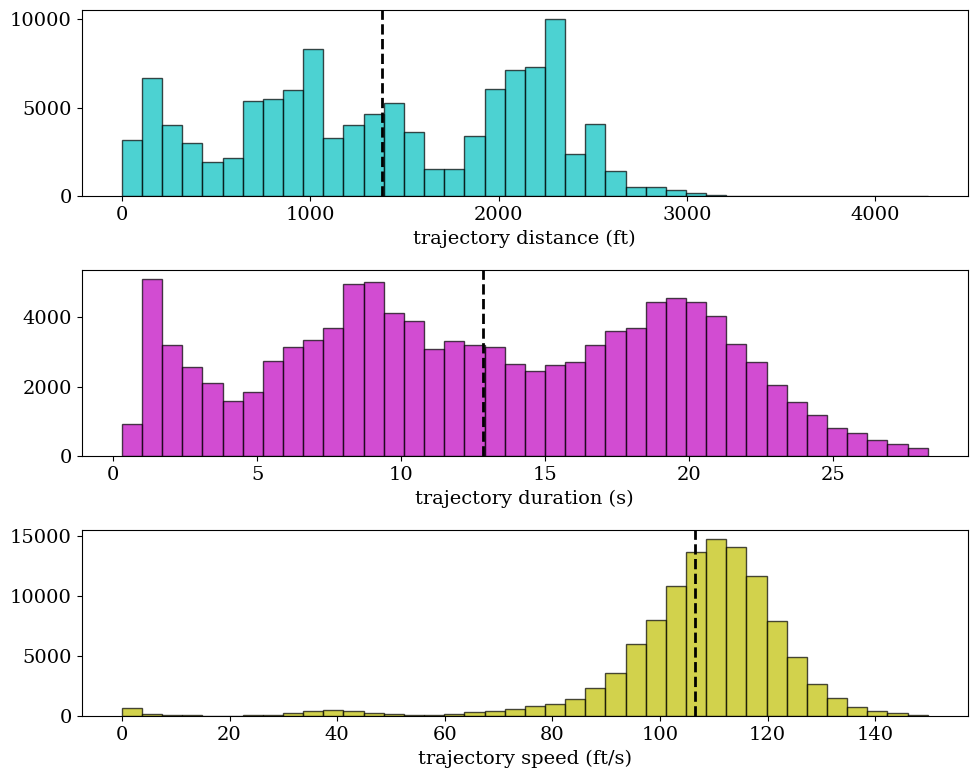

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8))

distances = traj_stats[traj_stats['travel_distance'] < traj_stats['travel_distance'].quantile(.995)]['travel_distance']
ax1.hist(traj_stats['travel_distance'], bins=40, 
         color='c', edgecolor='k', alpha=0.7)
ax1.axvline(distances.mean(), color='k', linestyle='dashed', linewidth=2)
ax1.set_xlabel('trajectory distance (ft)')

times = traj_stats[traj_stats['travel_time'] < traj_stats['travel_time'].quantile(.995)]['travel_time']
ax2.hist(times, bins=40, 
         color='m', edgecolor='k', alpha=0.7)
ax2.axvline(times.mean(), color='k', linestyle='dashed', linewidth=2)
ax2.set_xlabel('trajectory duration (s)')

speeds = traj_stats[traj_stats['travel_speed'] < traj_stats['travel_speed'].quantile(.995)]['travel_speed']
ax3.hist(speeds, bins=40, color='y', edgecolor='k', alpha=0.7)
ax3.axvline(traj_stats['travel_speed'].mean(), 
            color='k', linestyle='dashed', linewidth=2)
ax3.set_xlabel('trajectory speed (ft/s)')

plt.tight_layout()
plt.show()